In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
npileup = 200

## Let's load the data files

In [3]:
data_dir = os.path.join('..', '..', '..', 'data')
root_dir = os.path.join(data_dir, 'Pythia8', 'pileup-{}'.format(npileup))

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith('-hits.csv')])
hit_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
           for file in hit_files]

initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith('-particles_initial.csv')])
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]

final_files = sorted([file for file in os.listdir(root_dir) if file.endswith('-particles_final.csv')])
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

Let's load an event and check the performance of the Purified Hough Transform.

In [4]:
num_events = 100
random.seed(3082021)

random_event = random.choice(range(0, num_events))
df = hit_dfs[random_event]
initial_df = initial_dfs[random_event]

df['weight'] = 1
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['xy_track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df['rz_track'] = df[['r','tz']].apply(lambda pair: (-pair[0], pair[1]), 1)

initial_df['pt'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2)
initial_df['|p|'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2 + initial_df['pz'] ** 2)
initial_df['theta'] = np.arccos(initial_df['pz'] / initial_df['|p|'])
initial_df['eta'] = -np.log(np.tan(initial_df['theta'] / 2))

print(f'Event chosen: {hit_files[random_event]}')

initial_df.head()

Event chosen: event000000085-hits.csv


,particle_id,particle_type,process,vx,vy,vz,vt,px,py,pz,m,q,pt,|p|,theta,eta
0,4503599644147712,-211,0,0.021071,0.013023,-128.09848,-4.308757,0.131345,-0.152092,285.414795,0.13957,-1,0.200957,285.414866,0.000704,7.951757
1,4503599660924928,-211,0,0.021071,0.013023,-128.09848,-4.308757,0.134854,-0.087754,-186.238205,0.13957,-1,0.160893,186.238274,3.140729,-7.747191
2,4503599677702144,-321,0,0.021071,0.013023,-128.09848,-4.308757,-0.753295,0.684963,-219.511871,0.49368,-1,1.018149,219.514232,3.136954,-6.066572
3,4503599728033792,-321,0,0.021071,0.013023,-128.09848,-4.308757,-0.057815,-0.155811,2.238906,0.49368,-1,0.166192,2.245066,0.074093,3.295123
4,4503599744811008,211,0,0.021071,0.013023,-128.09848,-4.308757,-0.352381,0.020453,6.702408,0.13957,1,0.352974,6.711696,0.052615,3.637666


In [5]:
def remove_low_pt_tracks(_df, _initial_df):
    """ Removes tracks with truth pt smaller than 0.5 GeV """
    low_pt_pids = []
    for row, series in _initial_df.iterrows():
        if series['pt'] < 0.5:
            low_pt_pids.append(series['particle_id'])

    _df = _df[~_df['particle_id'].isin(low_pt_pids)]
    _initial_df = _initial_df[~_initial_df['particle_id'].isin(low_pt_pids)]

    return _df.copy().reset_index(), _initial_df.copy().reset_index()

print('Shape Before')
print(df.shape)
print(initial_df.shape)
print()

df, initial_df = remove_low_pt_tracks(df, initial_df)

print('Shape After')
print(df.shape)
print(initial_df.shape)

Shape Before
(309, 20)
(79, 16)

Shape After
(161, 21)
(32, 17)


Text(0.5, 1.0, 'xy view')

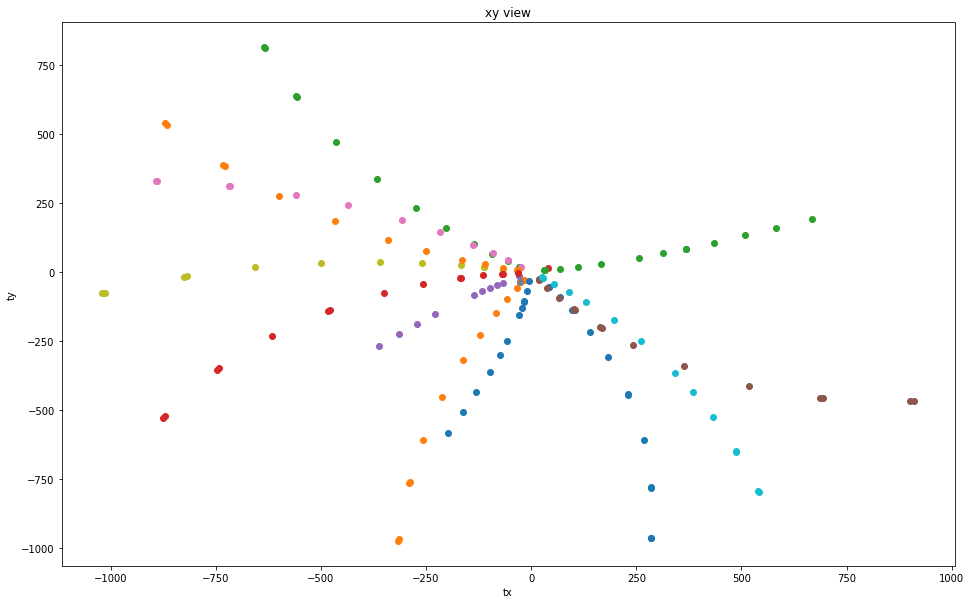

In [6]:
particles = set(df['particle_id'])

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
for pid in particles:
    particle_df = df[df['particle_id'] == pid]
    ax.scatter(particle_df['tx'], particle_df['ty'])

ax.set_xlabel('tx')
ax.set_ylabel('ty')
ax.set_title('xy view')

Hyperparameters

In [7]:
xy_hyperparams = {
    'bin-size': (0.001, 0.2),
    'xrange': (-np.pi, np.pi),
    'yrange': (-1000, 1000),
    'minimum-hits-per-bin': 10
}

rz_hyperparams = {
    'bin-size': (0.04, 20),
    'xrange': (-15, 15),
    'yrange': (-50000, 50000),
    'minimum-hits-per-bin': 6
}

threshold_x = 3500 * xy_hyperparams['bin-size'][0]
threshold_y = 1000 * xy_hyperparams['bin-size'][1]
closeness_thresholds = (threshold_x, threshold_y)
similarity_threshold = 0.5


Import algorithms

In [8]:
from src.utils.hough_transform import compute_approximate_qpt, hough2d_pipeline
from src.utils.duplicate_removal import purify_xy_estimations
from src.utils.duplicate_removal import get_track_to_geometry_mapping, duplicate_removal_1
from src.utils.metrics import efficiency_rate, fake_rate, duplicate_rate

In [9]:
def compute_and_print_results(est, transform_type, _df):
    """ Computes metrics and prints them. """
    eff = efficiency_rate(est.values(), _df)
    fake = fake_rate(est.values(), _df)
    dup = duplicate_rate(est.values(), _df)
    print(f'{transform_type} statistics:')
    print(f'\tEfficiency Rate: {eff:.2f}')
    print(f'\tFake Rate: {fake:.2f}')
    print(f'\tDuplicate Rate: {dup:.2f}')
    print(f'\tNumber of tracks estimated: {len(est)}')
    print()

In [10]:
# run the Hough Transform
df['track'] = df['xy_track']
_, xy_est = hough2d_pipeline(list(df['track']), xy_hyperparams, compute_approximate_qpt)
compute_and_print_results(xy_est, 'xy Transform', df)

# purify the results
pur_xy_est = purify_xy_estimations(xy_est, rz_hyperparams, df)
compute_and_print_results(pur_xy_est, 'Purified xy Transform', df)

# remove duplicates
hit_to_geom = get_track_to_geometry_mapping(df)
pur_new_est = duplicate_removal_1(pur_xy_est,
                                  closeness_thresholds,
                                  similarity_threshold,
                                  remove_same_geometries=False,
                                  hit_to_geom=hit_to_geom)
compute_and_print_results(pur_new_est, 'Purified xy Transform (Duplicate Removal 1)', df)

# remove reconstructed tracks with P_T bigger than 0.6 GeV
final_est = {track: hits for track, hits in pur_new_est.items()
             if abs(track[1]) < (1 / 0.6)}
compute_and_print_results(final_est, 'Purified xy Transform (Duplicate Removal 1) Filtered Reco tracks with pt > 0.6 GeV', df)

xy Transform statistics:
	Efficiency Rate: 0.79
	Fake Rate: 0.00
	Duplicate Rate: 0.89
	Number of tracks estimated: 97

Purified xy Transform statistics:
	Efficiency Rate: 0.79
	Fake Rate: 0.00
	Duplicate Rate: 0.89
	Number of tracks estimated: 97

Purified xy Transform (Duplicate Removal 1) statistics:
	Efficiency Rate: 0.79
	Fake Rate: 0.00
	Duplicate Rate: 0.15
	Number of tracks estimated: 13

Purified xy Transform (Duplicate Removal 1) Filtered Reco tracks with pt > 0.6 GeV statistics:
	Efficiency Rate: 0.71
	Fake Rate: 0.00
	Duplicate Rate: 0.17
	Number of tracks estimated: 12



Let's define a custom efficiency rate function that will also return the particles found.

In [11]:
from src.utils.metrics import get_track_to_truth_row_mapping, matching_probability

def custom_efficiency_rate(est, truth_df, threshold=0.5):
    """ Custom efficiency rate function. The difference is that it also returns the reconstructed particles. """
    num_true_particles = len(set(truth_df['particle_id']))
    track_to_truth_df_row = get_track_to_truth_row_mapping(truth_df)
    found_particles = set()
    pid_to_est_track = {}

    for _track, hits in est.items():
        _pid, prob = matching_probability(hits, track_to_truth_df_row, truth_df)
        if prob >= threshold and _pid not in found_particles:
            found_particles.add(_pid)
            pid_to_est_track[_pid] = _track
        if len(found_particles) == num_true_particles:
            break

    return pid_to_est_track, len(found_particles) / len(set(truth_df['particle_id']))

Now let's take a look at which particles were found, in order to see the frequency for every pdg.

In [12]:
particle_to_track, efficiency = custom_efficiency_rate(pur_new_est, df)
real_counts_per_pdg = dict(initial_df['particle_type'].value_counts())
reco_counts_per_pdg = {pdg: 0 for pdg in real_counts_per_pdg}

for reco_particle in particle_to_track:
    pdg = initial_df[initial_df['particle_id'] == reco_particle]['particle_type'].iloc[0]
    reco_counts_per_pdg[pdg] += 1

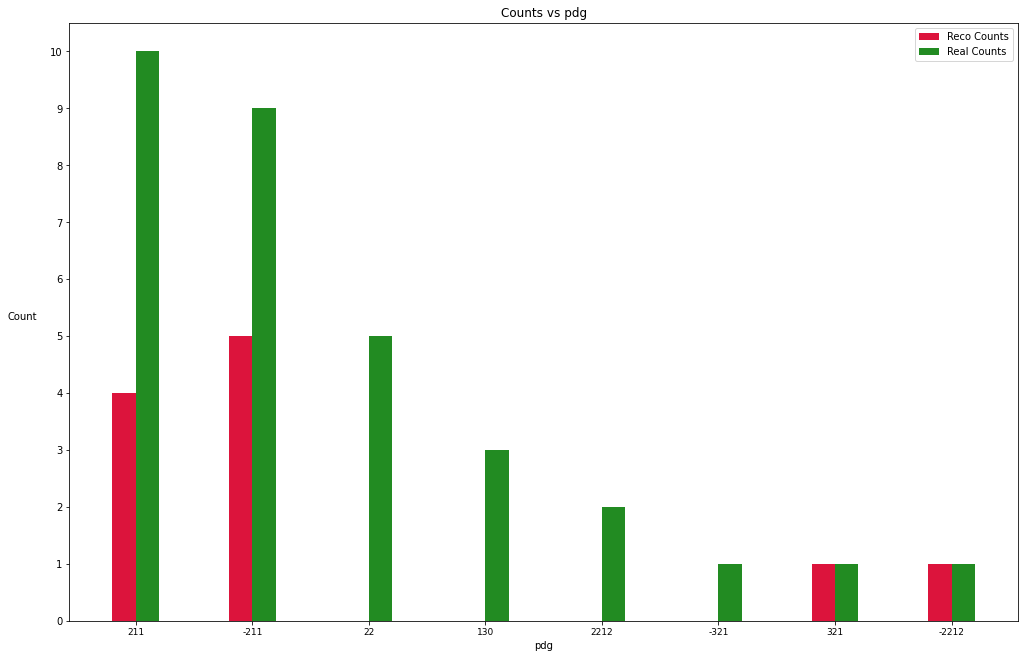

In [13]:
_, ax = plt.subplots(1, 1, figsize=(17, 11))

# first plot: residual per phi
n_pdgs = len(real_counts_per_pdg)
xticks_r = np.arange(0, n_pdgs)
count_max = max(real_counts_per_pdg.values())
bar_width = 0.2

ax.bar(xticks_r - (bar_width / 2), list(reco_counts_per_pdg.values()), color='crimson',
       label='Reco Counts', width=bar_width)
ax.bar(xticks_r + (bar_width / 2), list(real_counts_per_pdg.values()), color='forestgreen',
       label='Real Counts', width=bar_width)

ax.set_xlabel('pdg')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(real_counts_per_pdg), fontsize=9)
ax.set_ylabel('Count').set_rotation(0)
ax.yaxis.set_label_coords(-0.05, 0.50)
ax.set_yticks(np.arange(0, count_max + 1))
ax.set_title('Counts vs pdg')
ax.legend()

plt.show()